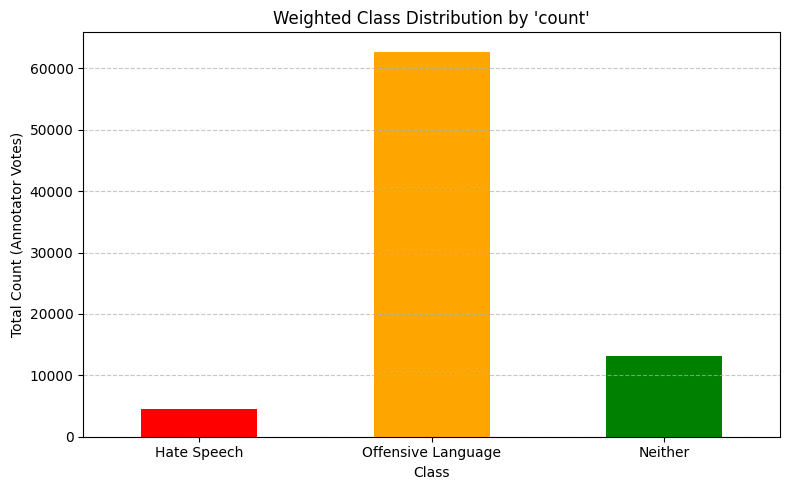

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load dataset
df = pd.read_csv('/content/labeled_data.csv')

# Group by class and sum the counts to get weighted class frequencies
weighted_class_counts = df.groupby('class')['count'].sum()

# Map class numbers to names
class_names = {0: "Hate Speech", 1: "Offensive Language", 2: "Neither"}
weighted_class_counts.index = weighted_class_counts.index.map(class_names)

# Plot
plt.figure(figsize=(8, 5))
weighted_class_counts.plot(kind='bar', color=['red', 'orange', 'green'])
plt.title("Weighted Class Distribution by 'count'")
plt.xlabel("Class")
plt.ylabel("Total Count (Annotator Votes)")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
from tensorflow.keras.layers import Bidirectional

# Drop unused columns
df = df.drop(columns=['count'])

# Features and labels
X = df['tweet']
y = df['class']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------
# 1️⃣ TF-IDF + Logistic Regression
# -------------------------
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

lr_model = LogisticRegression()
lr_model.fit(X_train_tfidf, y_train)
lr_preds = lr_model.predict(X_test_tfidf)

lr_acc = accuracy_score(y_test, lr_preds)
print("Logistic Regression Accuracy:", lr_acc)

# -------------------------
# 2️⃣ TF-IDF + Naive Bayes
# -------------------------
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_preds = nb_model.predict(X_test_tfidf)

nb_acc = accuracy_score(y_test, nb_preds)
print("Naive Bayes Accuracy:", nb_acc)

# -------------------------
# 3️⃣ LSTM Model
# -------------------------
# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=50, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=50, padding='post')

# # LSTM model
# lstm_model = Sequential([
#     Embedding(input_dim=10000, output_dim=64, input_length=50),
#     LSTM(64),
#     Dense(32, activation='relu'),
#     Dense(3, activation='softmax')  # 3 classes: hate/offensive/neutral
# ])

# lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# lstm_model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_split=0.1)

# lstm_loss, lstm_acc = lstm_model.evaluate(X_test_pad, y_test)
# print("LSTM Accuracy:", lstm_acc)

# Updated Bidirectional LSTM model
bilstm_model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=50),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes
])

bilstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

bilstm_model.summary()

# Train the model
bilstm_model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_split=0.1)

# Evaluate
bilstm_loss, bilstm_acc = bilstm_model.evaluate(X_test_pad, y_test)
print("Bidirectional LSTM Accuracy:", bilstm_acc)

Logistic Regression Accuracy: 0.892071817631632
Naive Bayes Accuracy: 0.8254992939277789


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8122 - loss: 0.5769 - val_accuracy: 0.9102 - val_loss: 0.2899
Epoch 2/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9219 - loss: 0.2429 - val_accuracy: 0.9002 - val_loss: 0.2781
Epoch 3/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.9375 - loss: 0.1862 - val_accuracy: 0.8971 - val_loss: 0.2822
Epoch 4/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9613 - loss: 0.1164 - val_accuracy: 0.8921 - val_loss: 0.3401
Epoch 5/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9726 - loss: 0.0802 - val_accuracy: 0.8916 - val_loss: 0.3757
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8813 - loss: 0.3987
Bidirectional LSTM Accuracy: 0.8811781406402588


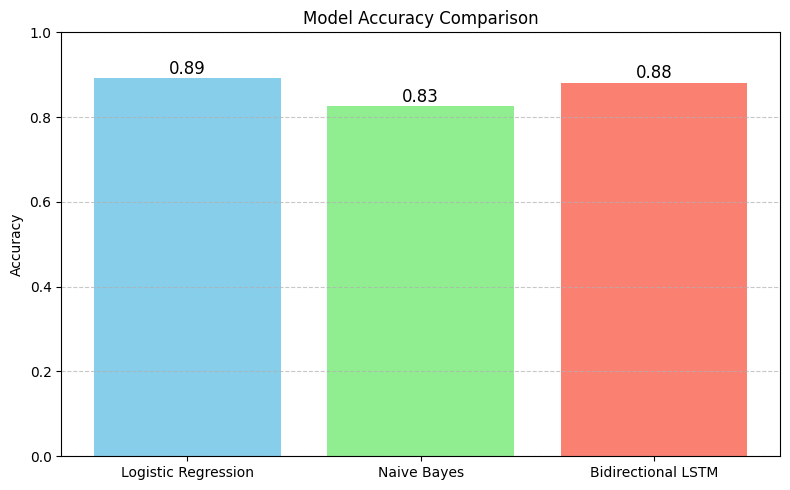

In [15]:
import matplotlib.pyplot as plt

# Store model names and their accuracies
model_names = ['Logistic Regression', 'Naive Bayes', 'Bidirectional LSTM']
accuracies = [lr_acc, nb_acc, bilstm_acc]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.2f}", ha='center', fontsize=12)

plt.tight_layout()
plt.show()

In [16]:
def predict_class(sentence):
    # TF-IDF input
    tfidf_input = tfidf.transform([sentence])

    lr_pred = lr_model.predict(tfidf_input)[0]
    nb_pred = nb_model.predict(tfidf_input)[0]

    # BiLSTM input
    seq = tokenizer.texts_to_sequences([sentence])
    padded = pad_sequences(seq, maxlen=50, padding='post')
    bilstm_probs = bilstm_model.predict(padded)
    bilstm_pred = bilstm_probs.argmax(axis=-1)[0]

    label_map = {
        0: "Hate Speech",
        1: "Offensive Language",
        2: "Neither"
    }

    print(f"\n🔍 Input: {sentence}")
    print(f"🧠 Logistic Regression: {label_map[lr_pred]}")
    print(f"🧠 Naive Bayes: {label_map[nb_pred]}")
    print(f"🧠 BiLSTM: {label_map[bilstm_pred]}")

In [20]:
predict_class("You are an idot")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

🔍 Input: You are an idot
🧠 Logistic Regression: Offensive Language
🧠 Naive Bayes: Offensive Language
🧠 BiLSTM: Offensive Language
